# Method 5 - Best Minus Rest Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Managers with Best Fresh Ideas

fresh_idea_mgrs = valid_data.merge(flat_qty).merge(flat_pos_size)
fresh_idea_mgrs = fresh_idea_mgrs[fresh_idea_mgrs['pos_rank'] == 1][['datadate', 'institution_id']].drop_duplicates()
fresh_idea_mgrs['fresh'] = 1

# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()
long_ideas = long_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')
                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()
short_ideas = short_ideas.merge(fresh_idea_mgrs, on=['datadate', 'institution_id'], how='inner')

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

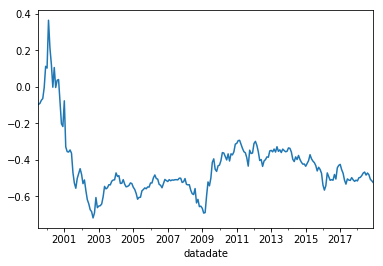

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.111903
2000-12-31   -0.296634
2001-12-31   -0.295034
2002-12-31   -0.387374
2003-12-31    0.452118
2004-12-31   -0.042002
2005-12-31   -0.041307
2006-12-31    0.079263
2007-12-31   -0.013150
2008-12-31   -0.278549
2009-12-31    0.638686
2010-12-31    0.209405
2011-12-31   -0.071073
2012-12-31    0.018187
2013-12-31   -0.003573
2014-12-31   -0.107533
2015-12-31   -0.088450
2016-12-31    0.082853
2017-12-31   -0.142561
2018-12-31   -0.027617
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     89.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-45
Time:                        04:35:54   Log-Likelihood:                 407.54
No. Observations:                 234   AIC:                            -805.1
Df Residuals:                     229   BIC:                            -787.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.150      0.881      -0.005       0.006
mktrf          0.3945      0.080      4.935      0.000       0.237       0.552
me             0.3829      0.093      4.118      0.000       0.200       0.566
ia            -0.2271      0.141     -1.607      0.109      -0.506       0.051
roe           -1.0909      0.121     -9.018      0.000      -1.329      -0.853
==============================================================================
Omnibus:                       47.850   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.718
Skew:                           0.736   Prob(JB):                     1.16e-43
Kurtosis:                       7.256   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     101.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-49
Time:                        04:35:54   Log-Likelihood:                 407.54
No. Observations:                 234   AIC:                            -805.1
Df Residuals:                     229   BIC:                            -787.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.162      0.872      -0.005       0.006
mktrf          0.3945      0.108      3.662      0.000       0.183       0.606
me             0.3829      0.113      3.375      0.001       0.161       0.605
ia            -0.2271      0.220     -1.034      0.301      -0.658       0.203
roe           -1.0909      0.222     -4.917      0.000      -1.526      -0.656
==============================================================================
Omnibus:                       47.850   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.718
Skew:                           0.736   Prob(JB):                     1.16e-43
Kurtosis:                       7.256   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     152.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.04e-63
Time:                        04:35:54   Log-Likelihood:                 407.54
No. Observations:                 234   AIC:                            -805.1
Df Residuals:                     229   BIC:                            -787.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.154      0.878      -0.005       0.006
mktrf          0.3945      0.114      3.447      0.001       0.170       0.619
me             0.3829      0.117      3.260      0.001       0.153       0.613
ia            -0.2271      0.219     -1.035      0.301      -0.657       0.203
roe           -1.0909      0.218     -5.010      0.000      -1.518      -0.664
==============================================================================
Omnibus:                       47.850   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.718
Skew:                           0.736   Prob(JB):                     1.16e-43
Kurtosis:                       7.256   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     71.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.39e-44
Time:                        04:35:54   Log-Likelihood:                 407.48
No. Observations:                 234   AIC:                            -803.0
Df Residuals:                     228   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.290      0.772      -0.005       0.007
mktrf          0.4521      0.080      5.631      0.000       0.294       0.610
smb            0.3046      0.106      2.875      0.004       0.096       0.513
hml            0.1398      0.125      1.119      0.264      -0.106       0.386
rmw           -1.2022      0.141     -8.511      0.000      -1.481      -0.924
cma           -0.0661      0.180     -0.368      0.713      -0.420       0.288
==============================================================================
Omnibus:                       82.401   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.345
Skew:                           1.345   Prob(JB):                     2.31e-81
Kurtosis:                       8.555   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     47.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-33
Time:                        04:35:54   Log-Likelihood:                 407.48
No. Observations:                 234   AIC:                            -803.0
Df Residuals:                     228   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.344      0.731      -0.004       0.006
mktrf          0.4521      0.086      5.234      0.000       0.283       0.621
smb            0.3046      0.104      2.941      0.003       0.102       0.508
hml            0.1398      0.208      0.671      0.502      -0.268       0.548
rmw           -1.2022      0.185     -6.513      0.000      -1.564      -0.840
cma           -0.0661      0.293     -0.225      0.822      -0.641       0.509
==============================================================================
Omnibus:                       82.401   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.345
Skew:                           1.345   Prob(JB):                     2.31e-81
Kurtosis:                       8.555   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     53.93
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.54e-37
Time:                        04:35:54   Log-Likelihood:                 407.48
No. Observations:                 234   AIC:                            -803.0
Df Residuals:                     228   BIC:                            -782.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.321      0.748      -0.004       0.006
mktrf          0.4521      0.080      5.648      0.000       0.295       0.609
smb            0.3046      0.107      2.847      0.004       0.095       0.514
hml            0.1398      0.170      0.823      0.411      -0.193       0.473
rmw           -1.2022      0.181     -6.658      0.000      -1.556      -0.848
cma           -0.0661      0.278     -0.238      0.812      -0.611       0.479
==============================================================================
Omnibus:                       82.401   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.345
Skew:                           1.345   Prob(JB):                     2.31e-81
Kurtosis:                       8.555   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     81.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.15e-43
Time:                        04:35:54   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.003     -1.033      0.303      -0.009       0.003
mktrf          0.5507      0.076      7.283      0.000       0.402       0.700
smb            0.8745      0.094      9.264      0.000       0.688       1.060
hml           -0.2571      0.094     -2.742      0.007      -0.442      -0.072
umd           -0.4441      0.062     -7.218      0.000      -0.565      -0.323
==============================================================================
Omnibus:                       45.115   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.567
Skew:                           0.839   Prob(JB):                     4.00e-27
Kurtosis:                       6.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     39.46
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.05e-25
Time:                        04:35:54   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.265      0.206      -0.008       0.002
mktrf          0.5507      0.087      6.359      0.000       0.381       0.720
smb            0.8745      0.110      7.977      0.000       0.660       1.089
hml           -0.2571      0.138     -1.857      0.063      -0.528       0.014
umd           -0.4441      0.106     -4.184      0.000      -0.652      -0.236
==============================================================================
Omnibus:                       45.115   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.567
Skew:                           0.839   Prob(JB):                     4.00e-27
Kurtosis:                       6.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     48.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.54e-29
Time:                        04:35:54   Log-Likelihood:                 401.20
No. Observations:                 234   AIC:                            -792.4
Df Residuals:                     229   BIC:                            -775.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.246      0.213      -0.008       0.002
mktrf          0.5507      0.091      6.043      0.000       0.372       0.729
smb            0.8745      0.103      8.497      0.000       0.673       1.076
hml           -0.2571      0.141     -1.822      0.068      -0.534       0.019
umd           -0.4441      0.102     -4.348      0.000      -0.644      -0.244
==============================================================================
Omnibus:                       45.115   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.567
Skew:                           0.839   Prob(JB):                     4.00e-27
Kurtosis:                       6.107   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     46.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.31e-23
Time:                        04:35:54   Log-Likelihood:                 187.50
No. Observations:                 120   AIC:                            -365.0
Df Residuals:                     115   BIC:                            -351.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.464      0.644      -0.008       0.012
mktrf          0.3622      0.134      2.712      0.008       0.098       0.627
me             0.3114      0.132      2.361      0.020       0.050       0.573
ia            -0.3959      0.207     -1.917      0.058      -0.805       0.013
roe           -1.0771      0.183     -5.892      0.000      -1.439      -0.715
==============================================================================
Omnibus:                       18.262   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.431
Skew:                           0.594   Prob(JB):                     4.52e-09
Kurtosis:                       5.505   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     97.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.25e-36
Time:                        04:35:54   Log-Likelihood:                 187.50
No. Observations:                 120   AIC:                            -365.0
Df Residuals:                     115   BIC:                            -351.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.524      0.600      -0.006       0.011
mktrf          0.3622      0.155      2.344      0.019       0.059       0.665
me             0.3114      0.153      2.037      0.042       0.012       0.611
ia            -0.3959      0.300     -1.320      0.187      -0.984       0.192
roe           -1.0771      0.298     -3.615      0.000      -1.661      -0.493
==============================================================================
Omnibus:                       18.262   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.431
Skew:                           0.594   Prob(JB):                     4.52e-09
Kurtosis:                       5.505   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     134.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.31e-42
Time:                        04:35:54   Log-Likelihood:                 187.50
No. Observations:                 120   AIC:                            -365.0
Df Residuals:                     115   BIC:                            -351.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.004      0.524      0.601      -0.006       0.011
mktrf          0.3622      0.164      2.209      0.027       0.041       0.684
me             0.3114      0.157      1.982      0.048       0.003       0.619
ia            -0.3959      0.293     -1.353      0.176      -0.970       0.178
roe           -1.0771      0.305     -3.535      0.000      -1.674      -0.480
==============================================================================
Omnibus:                       18.262   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.431
Skew:                           0.594   Prob(JB):                     4.52e-09
Kurtosis:                       5.505   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     37.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.46e-22
Time:                        04:35:54   Log-Likelihood:                 188.04
No. Observations:                 120   AIC:                            -364.1
Df Residuals:                     114   BIC:                            -347.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.005      0.745      0.458      -0.006       0.014
mktrf          0.5223      0.141      3.709      0.000       0.243       0.801
smb            0.2540      0.159      1.593      0.114      -0.062       0.570
hml           -0.1166      0.195     -0.597      0.552      -0.504       0.271
rmw           -1.0101      0.230     -4.384      0.000      -1.467      -0.554
cma           -0.0282      0.252     -0.112      0.911      -0.528       0.472
==============================================================================
Omnibus:                       48.204   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.999
Skew:                           1.472   Prob(JB):                     1.98e-32
Kurtosis:                       7.531   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     40.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.21e-24
Time:                        04:35:54   Log-Likelihood:                 188.04
No. Observations:                 120   AIC:                            -364.1
Df Residuals:                     114   BIC:                            -347.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.092      0.275      -0.003       0.011
mktrf          0.5223      0.167      3.126      0.002       0.195       0.850
smb            0.2540      0.149      1.700      0.089      -0.039       0.547
hml           -0.1166      0.182     -0.641      0.521      -0.473       0.240
rmw           -1.0101      0.245     -4.127      0.000      -1.490      -0.530
cma           -0.0282      0.350     -0.081      0.936      -0.715       0.658
==============================================================================
Omnibus:                       48.204   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.999
Skew:                           1.472   Prob(JB):                     1.98e-32
Kurtosis:                       7.531   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     45.30
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-25
Time:                        04:35:54   Log-Likelihood:                 188.04
No. Observations:                 120   AIC:                            -364.1
Df Residuals:                     114   BIC:                            -347.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.143      0.253      -0.003       0.010
mktrf          0.5223      0.148      3.520      0.000       0.231       0.813
smb            0.2540      0.148      1.716      0.086      -0.036       0.544
hml           -0.1166      0.143     -0.814      0.415      -0.397       0.164
rmw           -1.0101      0.249     -4.051      0.000      -1.499      -0.521
cma           -0.0282      0.328     -0.086      0.931      -0.672       0.615
==============================================================================
Omnibus:                       48.204   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.999
Skew:                           1.472   Prob(JB):                     1.98e-32
Kurtosis:                       7.531   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     52.82
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.49e-25
Time:                        04:35:54   Log-Likelihood:                 192.30
No. Observations:                 120   AIC:                            -374.6
Df Residuals:                     115   BIC:                            -360.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.005     -0.194      0.846      -0.010       0.008
mktrf          0.5846      0.113      5.172      0.000       0.361       0.809
smb            0.8092      0.129      6.288      0.000       0.554       1.064
hml           -0.4902      0.129     -3.802      0.000      -0.745      -0.235
umd           -0.4258      0.079     -5.357      0.000      -0.583      -0.268
==============================================================================
Omnibus:                       24.206   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.894
Skew:                           0.856   Prob(JB):                     1.08e-10
Kurtosis:                       5.500   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     41.68
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.48e-21
Time:                        04:35:54   Log-Likelihood:                 192.30
No. Observations:                 120   AIC:                            -374.6
Df Residuals:                     115   BIC:                            -360.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.275      0.784      -0.007       0.006
mktrf          0.5846      0.124      4.721      0.000       0.342       0.827
smb            0.8092      0.118      6.836      0.000       0.577       1.041
hml           -0.4902      0.125     -3.918      0.000      -0.735      -0.245
umd           -0.4258      0.114     -3.747      0.000      -0.648      -0.203
==============================================================================
Omnibus:                       24.206   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.894
Skew:                           0.856   Prob(JB):                     1.08e-10
Kurtosis:                       5.500   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     54.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-25
Time:                        04:35:54   Log-Likelihood:                 192.30
No. Observations:                 120   AIC:                            -374.6
Df Residuals:                     115   BIC:                            -360.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.294      0.769      -0.007       0.005
mktrf          0.5846      0.127      4.596      0.000       0.335       0.834
smb            0.8092      0.108      7.505      0.000       0.598       1.021
hml           -0.4902      0.112     -4.387      0.000      -0.709      -0.271
umd           -0.4258      0.114     -3.724      0.000      -0.650      -0.202
==============================================================================
Omnibus:                       24.206   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.894
Skew:                           0.856   Prob(JB):                     1.08e-10
Kurtosis:                       5.500   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     43.11
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.22e-21
Time:                        04:35:54   Log-Likelihood:                 237.50
No. Observations:                 114   AIC:                            -465.0
Df Residuals:                     109   BIC:                            -451.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.003     -0.215      0.830      -0.007       0.005
mktrf          0.3804      0.091      4.199      0.000       0.201       0.560
me             0.5655      0.140      4.044      0.000       0.288       0.843
ia             0.1166      0.194      0.601      0.549      -0.268       0.501
roe           -1.1037      0.170     -6.475      0.000      -1.442      -0.766
==============================================================================
Omnibus:                       23.470   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.568
Skew:                           0.901   Prob(JB):                     1.55e-09
Kurtosis:                       5.300   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     38.79
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.70e-20
Time:                        04:35:54   Log-Likelihood:                 237.50
No. Observations:                 114   AIC:                            -465.0
Df Residuals:                     109   BIC:                            -451.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.287      0.774      -0.005       0.004
mktrf          0.3804      0.117      3.261      0.001       0.152       0.609
me             0.5655      0.184      3.075      0.002       0.205       0.926
ia             0.1166      0.224      0.521      0.602      -0.322       0.555
roe           -1.1037      0.243     -4.546      0.000      -1.580      -0.628
==============================================================================
Omnibus:                       23.470   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.568
Skew:                           0.901   Prob(JB):                     1.55e-09
Kurtosis:                       5.300   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     49.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.50e-24
Time:                        04:35:54   Log-Likelihood:                 237.50
No. Observations:                 114   AIC:                            -465.0
Df Residuals:                     109   BIC:                            -451.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.285      0.776      -0.005       0.004
mktrf          0.3804      0.120      3.162      0.002       0.145       0.616
me             0.5655      0.209      2.704      0.007       0.156       0.975
ia             0.1166      0.231      0.504      0.615      -0.337       0.570
roe           -1.1037      0.240     -4.599      0.000      -1.574      -0.633
==============================================================================
Omnibus:                       23.470   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.568
Skew:                           0.901   Prob(JB):                     1.55e-09
Kurtosis:                       5.300   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     38.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.49e-22
Time:                        04:35:54   Log-Likelihood:                 241.86
No. Observations:                 114   AIC:                            -471.7
Df Residuals:                     108   BIC:                            -455.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.421      0.675      -0.007       0.005
mktrf          0.4014      0.084      4.805      0.000       0.236       0.567
smb            0.4364      0.136      3.218      0.002       0.168       0.705
hml            0.5079      0.173      2.937      0.004       0.165       0.851
rmw           -1.2450      0.212     -5.879      0.000      -1.665      -0.825
cma           -0.0991      0.269     -0.369      0.713      -0.632       0.434
==============================================================================
Omnibus:                        5.501   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.101
Skew:                           0.398   Prob(JB):                       0.0780
Kurtosis:                       3.663   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     27.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.05e-18
Time:                        04:35:54   Log-Likelihood:                 241.86
No. Observations:                 114   AIC:                            -471.7
Df Residuals:                     108   BIC:                            -455.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.406      0.685      -0.007       0.005
mktrf          0.4014      0.080      5.008      0.000       0.244       0.558
smb            0.4364      0.135      3.239      0.001       0.172       0.700
hml            0.5079      0.182      2.793      0.005       0.152       0.864
rmw           -1.2450      0.208     -5.977      0.000      -1.653      -0.837
cma           -0.0991      0.275     -0.361      0.718      -0.637       0.439
==============================================================================
Omnibus:                        5.501   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.101
Skew:                           0.398   Prob(JB):                       0.0780
Kurtosis:                       3.663   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     35.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.47e-21
Time:                        04:35:54   Log-Likelihood:                 241.86
No. Observations:                 114   AIC:                            -471.7
Df Residuals:                     108   BIC:                            -455.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.380      0.704      -0.008       0.005
mktrf          0.4014      0.083      4.864      0.000       0.240       0.563
smb            0.4364      0.148      2.949      0.003       0.146       0.726
hml            0.5079      0.143      3.548      0.000       0.227       0.788
rmw           -1.2450      0.190     -6.568      0.000      -1.617      -0.874
cma           -0.0991      0.277     -0.357      0.721      -0.643       0.445
==============================================================================
Omnibus:                        5.501   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.101
Skew:                           0.398   Prob(JB):                       0.0780
Kurtosis:                       3.663   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     33.64
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.89e-18
Time:                        04:35:54   Log-Likelihood:                 229.27
No. Observations:                 114   AIC:                            -448.5
Df Residuals:                     109   BIC:                            -434.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.816      0.416      -0.009       0.004
mktrf          0.4548      0.092      4.929      0.000       0.272       0.638
smb            0.7188      0.144      4.996      0.000       0.434       1.004
hml            0.4903      0.148      3.309      0.001       0.197       0.784
umd           -0.3236      0.112     -2.895      0.005      -0.545      -0.102
==============================================================================
Omnibus:                        9.737   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               11.854
Skew:                           0.491   Prob(JB):                      0.00267
Kurtosis:                       4.238   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     33.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.46e-18
Time:                        04:35:54   Log-Likelihood:                 229.27
No. Observations:                 114   AIC:                            -448.5
Df Residuals:                     109   BIC:                            -434.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.946      0.344      -0.008       0.003
mktrf          0.4548      0.094      4.820      0.000       0.270       0.640
smb            0.7188      0.148      4.871      0.000       0.430       1.008
hml            0.4903      0.184      2.660      0.008       0.129       0.852
umd           -0.3236      0.118     -2.750      0.006      -0.554      -0.093
==============================================================================
Omnibus:                        9.737   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               11.854
Skew:                           0.491   Prob(JB):                      0.00267
Kurtosis:                       4.238   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     39.47
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.12e-20
Time:                        04:35:54   Log-Likelihood:                 229.27
No. Observations:                 114   AIC:                            -448.5
Df Residuals:                     109   BIC:                            -434.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.942      0.346      -0.008       0.003
mktrf          0.4548      0.097      4.697      0.000       0.265       0.645
smb            0.7188      0.140      5.136      0.000       0.444       0.993
hml            0.4903      0.171      2.871      0.004       0.156       0.825
umd           -0.3236      0.123     -2.634      0.008      -0.564      -0.083
==============================================================================
Omnibus:                        9.737   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               11.854
Skew:                           0.491   Prob(JB):                      0.00267
Kurtosis:                       4.238   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""